# Active Inference model inversion: T-Maze Environment

In [1]:
import jax
import jax.numpy as jnp
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

from pymdp.jax.agent import Agent
from pymdp.envs import TMazeEnv
from pymdp import utils 
import numpy as np

## Environment

Here we consider an agent navigating a three-armed 'T-maze,' with the agent starting in a central location of the maze. The bottom arm of the maze contains an informative cue, which signals in which of the two top arms ('Left' or 'Right', the ends of the 'T') a reward is likely to be found. 

### Hidden states

The T-Maze environment is comprised of two hidden state factors:

- `Location`: a $4$-dimensional vector that encodes the current position of the agent, and can take the following values: {`CENTER`, `RIGHT ARM`, `LEFT ARM`, or `CUE LOCATION`}. For example, if the agent is in the `CUE LOCATION`, the current state of this factor would be $s_1 = [0 \ 0 \ 0 \ 1]$.

-`Reward Condition`: a $ 1 \ x \ 2 $ vector that encodes the reward condition of the trial: {`Reward on Right`, or `Reward on Left`}.  A trial where the condition is reward is `Reward on Left` is thus encoded as the state $s_2 = [0 \ 1]$.

The environment is designed such that when the agent is located in the `RIGHT ARM` and the reward condition is `Reward on Right`, the agent has a specified probability $a$ (where $a > 0.5$) of receiving a reward, and a low probability $b = 1 - a$ of receiving a 'loss' (we can think of this as an aversive or unpreferred stimulus). If the agent is in the `LEFT ARM` for the same reward condition, the reward probabilities are swapped, and the agent experiences loss with probability $a$, and reward with lower probability $b = 1 - a$. These reward contingencies are intuitively swapped for the `Reward on Left` condition. 

### Observations

The agent is equipped with three sensory channels or observation modalities: `Location`, `Reward`, and `Cue`. 

-  `Location`: a $4$-dimensional observation that encodes the sensed position of the agent, and can take the same values as the `Location` hidden state factor.
  
- `Reward` : a $3$-dimensional observation that can take the values `No Reward`, `Reward` or `Loss`.  The `No Reward` (index 0) observation is  observed whenever the agent isn't occupying one of the two T-maze arms (the right or left arms). The `Reward` (index 1) and `Loss` (index 2) observations are observed in the right and left arms of the T-maze, with associated probabilities that depend on the reward condition (i.e. on the value of the second hidden state factor).

- `Cue`: a $2$-dimensional observation that can take the values `Cue Right` or `Cue Left`. This observation signals the reward condition of the trial, and therefore in which arm the `Reward` observation is more probable. When the agent occupies the other two arms (the `RIGHT` or `LEFT` arms), the `Cue` observation will be `Cue Right` or `Cue Left` with equal probability. However (as we'll see below when we intialise the agent), the agent's beliefs about the likelihood mapping render these observations uninformative and irrelevant to state inference

## Initialize environment
Now we can initialize the T-maze environment using the built-in `TMazeEnv` class from the `pymdp.envs` module.

Choose reward probabilities $a$ and $b$, where $a$ and $b$ are the probabilities of reward / loss in the 'correct' arm, and the probabilities of loss / reward in the 'incorrect' arm. Which arm counts as 'correct' vs. 'incorrect' depends on the reward condition (state of the 2nd hidden state factor).

In [2]:
reward_probabilities = [0.98, 0.02] # probabilities used in the original SPM T-maze demo
env = TMazeEnv(reward_probs = reward_probabilities)
A_gp = env.get_likelihood_dist()
B_gp = env.get_transition_dist()

### Note on Controllable (and Uncontrollable-) Transition Dynamics

Importantly, some hidden state factors are _controllable_ by the agent, meaning that the probability of being in state $i$ at $t+1$ doesn't only depend on the state at $t$, but also on actions or _control states_. So now each transition likelihood encodes conditional probability distributions over states at $t+1$, where the conditioning variables are both the states at $t-1$ _and_ the actions at $t-1$. This extra conditioning on actions is encoded via an optional third dimension to each factor-specific `B` matrix.

For example, in our case the first hidden state factor (`Location`) is under the control of the agent, which means the corresponding transition likelihoods `B[0]` are index-able by both previous state and action.

## The generative model
Now we can move onto setting up the generative model of the agent - namely, the agent's beliefs about how hidden states give rise to observations, and how hidden states transition among eachother.

In almost all MDPs, the critical building blocks of this generative model are the agent's representation of the observation likelihood, which we'll refer to as `A_gm`, and its representation of the transition likelihood, or `B_gm`. 

Here, we assume the agent has a veridical representation of the rules of the T-maze (namely, how hidden states cause observations) as well as its ability to control its own movements with certain consequences (i.e. 'noiseless' transitions).

In [3]:
# make the generative model of each agent a copy of the true generative process likelihood array

base_A_gm = deepcopy(A_gp) 
base_B_gm = deepcopy(B_gp) 

num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=base_A_gm, B=base_B_gm)

base_D_gm = utils.obj_array_uniform(num_states)
base_D_gm[0] = utils.onehot(0, num_states[0])

base_C_gm = utils.obj_array_zeros(num_obs)
base_C_gm[1] = np.array([0., 3., -3.])

num_actions = 4


In [4]:
num_agents = 50  # number of different agents 

# construct all the generative models of all agents by copying the "base" generative model
# we're putting the batch-dimension (here: `num_agents`) in the leading dimension of each modality- or factor-specific sub-array
A_gm_all = [jnp.broadcast_to(jnp.array(a), (num_agents,) + a.shape) for a in base_A_gm]  # map the true observation likelihood to jax arrays
B_gm_all = [jnp.broadcast_to(jnp.array(b), (num_agents,) + b.shape) for b in base_B_gm]  # map the true transition likelihood to jax arrays
D_gm_all = [jnp.broadcast_to(jnp.array(d),  (num_agents,) + d.shape) for d in base_D_gm]
C_gm_all = [jnp.broadcast_to(jnp.array(c),  (num_agents,) + c.shape) for c in base_C_gm]
E_gm_all = jnp.ones((num_agents, num_actions))

## Introducing the `Agent()` class

In `pymdp`, we have abstracted much of the computations required for active inference into the `Agent()` class, a flexible object that can be used to store necessary aspects of the generative model, the agent's instantaneous observations and actions, and perform action / perception using functions like `Agent.infer_states` and `Agent.infer_policies`. 

An instance of `Agent` is straightforwardly initialized with a call to `Agent()` with a list of optional arguments.


In our call to `Agent()`, we need to constrain the default behavior with some of our T-Maze-specific needs. For example, we want to make sure that the agent's beliefs about transitions are constrained by the fact that it can only control the `Location` factor - _not_ the `Reward Condition` (which we assumed stationary across an epoch of time). Therefore we specify this using a list of indices that will be passed as the `control_fac_idx` argument of the `Agent()` constructor. 

Each element in the list specifies a hidden state factor (in terms of its index) that is controllable by the agent. Hidden state factors whose indices are _not_ in this list are assumed to be uncontrollable.

In [5]:
controllable_indices = [0] # this is a list of the indices of the hidden state factors that are controllable
agent = Agent(A_gm_all, B_gm_all, C_gm_all, D_gm_all, E_gm_all, control_fac_idx=controllable_indices)

In [6]:
import jax.tree_util as jtu

vals, tree = jtu.tree_flatten(agent)

print(tree)

PyTreeDef(CustomNode(Agent[(('A', 'B', 'C', 'D', 'E', 'gamma', 'qs', 'q_pi'), ('num_iter', 'num_obs', 'num_modalities', 'num_states', 'num_factors', 'num_controls', 'inference_algo', 'control_fac_idx', 'policy_len', 'policies', 'use_utility', 'use_states_info_gain', 'use_param_info_gain', 'action_selection'), (16, [4, 3, 2], 3, [4, 2], 2, [4, 1], 'VANILLA', [0], 1, DeviceArray([[[0, 0]],

             [[1, 0]],

             [[2, 0]],

             [[3, 0]]], dtype=int32), True, True, False, 'deterministic'))], [[*, *, *], [*, *], [*, *, *], [*, *], *, *, None, None]))


## Active Inference
Now we can start off the T-maze with an initial observation and run active inference via a loop over a desired time interval.

In [25]:
T = 5 # number of timesteps

emp_prior = D_gm_all
_obs = env.reset() # reset the environment and get an initial observation
obs = jnp.broadcast_to(jnp.array(_obs), (num_agents, num_modalities)) # everyone gets the same initial observation

agent_to_show = 1 # which agent to print the messages of over time

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Right", "Left"]
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION']
reward_observations = ['No reward','Reward!','Loss!']
cue_observations = ['Cue Right','Cue Left']

In [56]:
#TODO: understand why gradient returns nans for num_iter > 2

agent = Agent(A_gm_all, B_gm_all, C_gm_all, D_gm_all, E_gm_all, control_fac_idx=controllable_indices, num_iter=3)
def test(prior):
    loc_prior = [emp_prior[0], prior]
    qs = agent.infer_states(obs, loc_prior)

    return jnp.log(qs[1]).sum()

jax.grad(test)(emp_prior[1])

DeviceArray([[nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],
             [nan, nan],


In [24]:
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[_obs[0]], reward_observations[_obs[1]], cue_observations[_obs[2]]))

qs_list = []
measurements = {'actions': [], 'outcomes': [obs]}
for t in range(T):
    qs = agent.infer_states(obs, emp_prior)
    qs_list.append(qs.copy())

    q_pi, efe = agent.infer_policies(qs)

    actions = agent.sample_action(q_pi)
    emp_prior = agent.update_empirical_prior(actions, qs)

    measurements["actions"].append( actions )
    msg = """[Step {}] Action: [Move to {}]"""
    print(msg.format(t, location_observations[int(actions[agent_to_show, 0])]))

    obs = []
    for a in actions:
        obs.append( jnp.array(env.step(list(a))) )
    obs = jnp.stack(obs)
    measurements["outcomes"].append(obs)

    msg = """[Step {}] Observation: [{},  {}, {}]"""
    print(msg.format(t, location_observations[obs[agent_to_show, 0]], reward_observations[obs[agent_to_show, 1]], cue_observations[obs[agent_to_show, 2]]))
    
measurements['actions'] = jnp.stack(measurements['actions']).astype(jnp.int32)
measurements['outcomes'] = jnp.stack(measurements['outcomes'])
measurements['outcomes'] = measurements['outcomes'][None, :T]
measurements['actions'] = measurements['actions'][None]
reward_condition_beliefs = jnp.stack([qs_i[1] for qs_i in qs_list])

 === Starting experiment === 
 Reward condition: Right, Observation: [CENTER, No reward, Cue Left]
[Step 0] Action: [Move to CUE LOCATION]
[Step 0] Observation: [CUE LOCATION,  No reward, Cue Right]
[Step 1] Action: [Move to RIGHT ARM]
[Step 1] Observation: [RIGHT ARM,  Reward!, Cue Right]
[Step 2] Action: [Move to RIGHT ARM]
[Step 2] Observation: [RIGHT ARM,  Reward!, Cue Left]
[Step 3] Action: [Move to RIGHT ARM]
[Step 3] Observation: [RIGHT ARM,  Reward!, Cue Left]
[Step 4] Action: [Move to RIGHT ARM]
[Step 4] Observation: [RIGHT ARM,  Reward!, Cue Left]


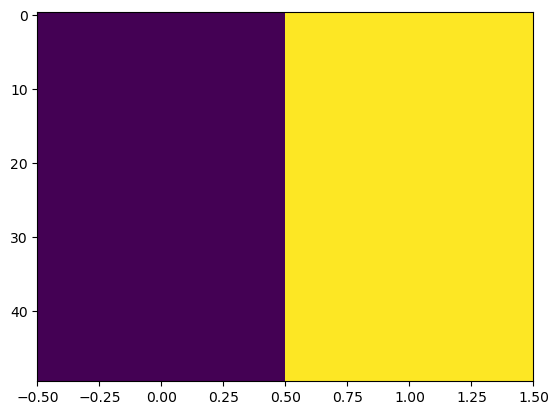

In [12]:
plt.imshow(reward_condition_beliefs[4], aspect='auto')

# Model inversion
Define model likelihood given the observed sequence of actions and outcomes

In [13]:
import numpyro as npyro
from jax import random
from numpyro.infer import Predictive
from pymdp.jax.likelihoods import aif_likelihood, evolve_trials

print(measurements['outcomes'].shape)
print(measurements['actions'].shape)

Nb, Nt, Na, _ = measurements['actions'].shape

xs = {'outcomes': measurements['outcomes'][0], 'actions': measurements['actions'][0]}
evolve_trials(agent, xs)
%timeit evolve_trials(agent, xs)

rng_key = random.PRNGKey(0)

with npyro.handlers.seed(rng_seed=0):
    aif_likelihood(Nb, Nt, Na, measurements, agent)

pred_samples = Predictive(aif_likelihood, num_samples=11)(rng_key, Nb, Nt, Na, measurements, agent)
%timeit pred_samples = Predictive(aif_likelihood, num_samples=11)(rng_key, Nb, Nt, Na, measurements, agent)
print(pred_samples.keys())

(1, 5, 50, 3)
(1, 5, 50, 2)
475 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
497 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
dict_keys(['actions', 'outcomes'])


In [14]:
import numpyro as npyro
import numpyro.distributions as dist
from jax import nn, lax, vmap

@vmap
def trans_params(z):

    a = nn.sigmoid(z[0])
    lam = nn.softplus(z[1])
    d = nn.sigmoid(z[2])

    A = lax.stop_gradient([jnp.array(x) for x in list(base_A_gm)])

    middle_matrix1 = jnp.array([[0., 0.], [a, 1-a], [1-a, a]])
    middle_matrix2 = jnp.array([[0., 0.], [1-a, a], [a, 1-a]])

    side_vector = jnp.stack([jnp.array([1.0, 0., 0.]), jnp.array([1.0, 0., 0.])], -1)

    A[1] = jnp.stack([side_vector, middle_matrix1, middle_matrix2, side_vector], -2)
    
    C = [
        jnp.zeros(4),
        lam * jnp.array([0., 1., -1.]),
        jnp.zeros(2)
    ]

    D = [nn.one_hot(0, 4), jnp.array([d, 1-d])]

    E = jnp.ones(4)/4

    params = {
        'A': A,
        'B': lax.stop_gradient([jnp.array(x) for x in list(base_B_gm)]),
        'C': C,
        'D': D,
        'E': E
    }

    return  params, a, lam, d

In [19]:
def model(data, num_blocks, num_steps, num_agents, num_params=3):
    with npyro.plate('agents', num_agents):
        z = npyro.sample('z', dist.Normal(0., 1.).expand([num_params]).to_event(1))
        params, a, lmbd, d = trans_params(z)
        # register parameter values
        npyro.deterministic('a', a)
        npyro.deterministic('lambda', lmbd)
        npyro.deterministic('d', d)

    agents = Agent(
        params['A'], 
        params['B'], 
        params['C'], 
        params['D'], 
        params['E'], 
        control_fac_idx=controllable_indices,
        num_iter=2
    )

    aif_likelihood(num_blocks, num_steps, num_agents, data, agents)
    
with npyro.handlers.seed(rng_seed=101111):
    model(measurements, Nb, Nt, Na)

%timeit pred_samples = Predictive(model, num_samples=11)(rng_key, measurements, Nb, Nt, Na)
pred_samples = Predictive(model, num_samples=11)(rng_key, measurements, Nb, Nt, Na)
print(pred_samples.keys())

603 ms ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
dict_keys(['a', 'actions', 'd', 'lambda', 'outcomes', 'z'])


In [22]:
# inference with NUTS and MCMC
from numpyro.infer import NUTS, MCMC
from numpyro.infer import init_to_feasible, init_to_sample, init_to_median

rng_key = random.PRNGKey(0)
kernel = NUTS(model, init_strategy=init_to_median)

mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=True)

rng_key, _rng_key = random.split(rng_key)
mcmc.run(_rng_key, measurements, Nb, Nt, Na)

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
import arviz as az
az.style.use('arviz-darkgrid')

coords = {
    'idx': jnp.arange(num_agents),
    'vars': jnp.arange(3), 
}
dims = {'z': ["idx", "vars"], 'd': ["idx"], 'lambda': ["idx"], 'a': ["idx"]}
data_kwargs = {
    "dims": dims,
    "coords": coords,
}
data_mcmc = az.from_numpyro(posterior=mcmc, **data_kwargs)
az.plot_trace(data_mcmc, kind="rank_bars", var_names=['d', 'lambda', 'a']);

#TODO: maybe plot real values on top of samples from the posterior

In [ ]:
# inference with SVI and autoguides
import optax
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoMultivariateNormal

num_iters = 1000
guide = AutoMultivariateNormal(model)
optimizer = npyro.optim.optax_to_numpyro(optax.chain(optax.adabelief(1e-3)))
svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=10))
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_iters, measurements, Nb, Nt, Na, progress_bar=True)

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(svi_res.losses)
plt.ylabel('Variational free energy');
plt.xlabel('iter step');

In [ ]:
rng_key, _rng_key = random.split(rng_key)
pred = Predictive(
    model, 
    guide=guide, 
    params=svi_res.params, 
    num_samples=1000, 
    return_sites=["d", "a", "lambda"]
)
post_sample = pred(_rng_key, measurements, Nb, Nt, Na)

for key in post_sample:
    post_sample[key] = jnp.expand_dims(post_sample[key], 0)

data_svi = az.convert_to_inference_data(post_sample, group="posterior", **data_kwargs)

In [ ]:
axes = az.plot_forest(
    [data_mcmc, data_svi],
    model_names = ["nuts", "svi"],
    kind='forestplot',
    var_names=['d', 'lambda', 'a'],
    coords={"idx": 0},
    combined=True,
    figsize=(20, 6)
)